In [14]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras import optimizers, metrics
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

root = '../dataset/hi'
root_soh = '../dataset/soh_charge'
root_model = '../model'


In [2]:

def load_and_process(root, root_soh, dataset):
    hiv = pd.read_csv(f'{root}/hiv-charge-CS2_{dataset}.csv')
    soh = pd.read_csv(f'{root_soh}/soh-CS2_{dataset}.csv')

    # Mantieni solo le colonne da hiv e soh
    df = pd.merge(hiv, soh, how="right", on="cycle")[["cycle", "hi_v", "SOH"]]
    df = df.drop(columns=["cycle"])
    df_hiv = df[["hi_v"]]
    df_soh = df[["SOH"]]
    return df_hiv.values, df_soh.values

# Carica e processa i dataset
df_33_hiv, df_33_soh = load_and_process(root, root_soh, 33)
df_35_hiv, df_35_soh = load_and_process(root, root_soh, 35)
df_37_hiv, df_37_soh = load_and_process(root, root_soh, 37)
df_36_hiv, df_36_soh = load_and_process(root, root_soh, 36)
df_38_hiv, df_38_soh = load_and_process(root, root_soh, 38)

# Stampa i dataset
print(df_35_hiv.shape)

(797, 1)


In [3]:
seq_length = 10

def split_sequence(data, seq_length, train=False):

    seq = []
    
    for j in data:
        ##to use all values
        # for i in range(len(j) - seq_length - 1):
        #     if train is True:
        #         seq.append(j[i:i+seq_length])
        #     else:
        #         seq.append(j[i + 1:i+seq_length + 1])
        for i in range(len(j) - seq_length):
            if train is True:
                seq.append(j[i:i+seq_length])
            else:
                seq.append(j[i+seq_length-1])
    if train:
        return np.array(seq)
    else:
        return np.array(seq)

In [4]:
# Create sequences for training set

X_train = split_sequence([df_36_hiv, df_38_hiv], seq_length, train=True)
y_train = split_sequence([df_36_soh, df_38_soh], seq_length)

# Calculate mean and std for normalization
mean = X_train.mean()
std = X_train.std()

# Standardize train data
X_train = (X_train - mean) / std

# Shuffle the sequences
perms = np.random.permutation(len(X_train))
X_train = X_train[perms]
y_train = y_train[perms]


print(X_train.shape, y_train.shape)

(1711, 10, 1) (1711, 1)


In [5]:
n_steps = 10
n_features = 1

#define optimizer
adam = optimizers.Adam(lr=0.00005, beta_1=0.9, beta_2=0.999)
# define model
model = Sequential()
# to use y_trai as x_train put return_sequences=True
model.add(LSTM(128, activation='relu', input_shape=(n_steps, n_features), return_sequences= False))
model.add(Dense(1))
model.compile(optimizer=adam, loss='mse', metrics=[metrics.RootMeanSquaredError()])

c:\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [6]:
# # Create sequences for testing set
X_test = split_sequence([df_35_hiv], seq_length, train = True)
y_test = split_sequence([df_35_soh], seq_length)

# # Normalize the test data using the mean and std from training data
X_test = (X_test - mean) / std

In [7]:
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)

# fit model
history = model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_data = (X_test, y_test),verbose=1, callbacks=[es])


Epoch 1/1000
14/14 [==============================] - 2s 42ms/step - loss: 0.7907 - root_mean_squared_error: 0.8892 - val_loss: 0.7907 - val_root_mean_squared_error: 0.8892
Epoch 2/1000
14/14 [==============================] - 0s 26ms/step - loss: 0.7576 - root_mean_squared_error: 0.8704 - val_loss: 0.7602 - val_root_mean_squared_error: 0.8719
Epoch 3/1000
14/14 [==============================] - 0s 24ms/step - loss: 0.7255 - root_mean_squared_error: 0.8518 - val_loss: 0.7304 - val_root_mean_squared_error: 0.8546
Epoch 4/1000
14/14 [==============================] - 0s 23ms/step - loss: 0.6940 - root_mean_squared_error: 0.8331 - val_loss: 0.7001 - val_root_mean_squared_error: 0.8367
Epoch 5/1000
14/14 [==============================] - 0s 27ms/step - loss: 0.6623 - root_mean_squared_error: 0.8138 - val_loss: 0.6696 - val_root_mean_squared_error: 0.8183
Epoch 6/1000
14/14 [==============================] - 0s 23ms/step - loss: 0.6305 - root_mean_squared_error: 0.7940 - val_loss: 0.6382 

In [16]:
model.save(f'{root_model}/LSTM.h5') 
print(history.history.keys())

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


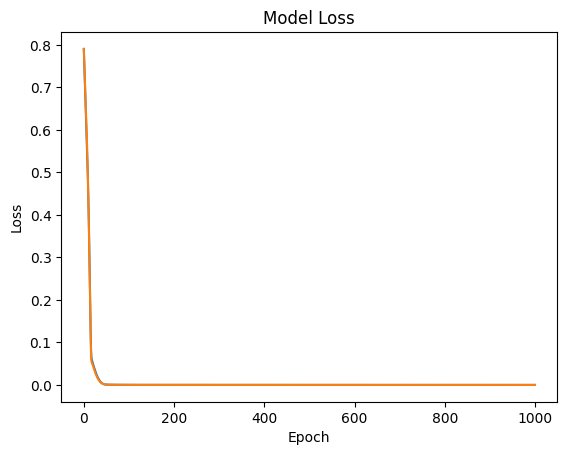

In [9]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'val')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

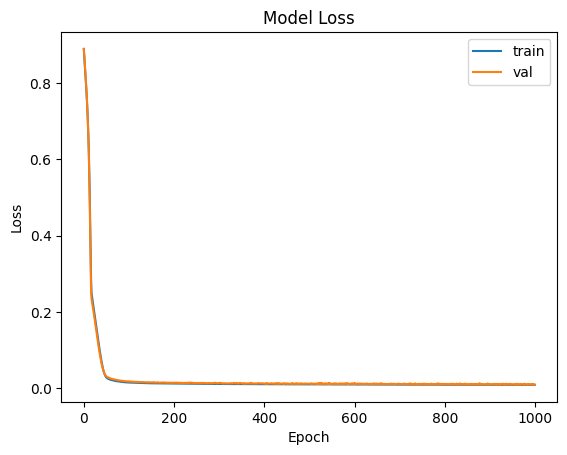

In [10]:
plt.plot(history.history['root_mean_squared_error'], label = 'train')
plt.plot(history.history['val_root_mean_squared_error'], label = 'val')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [11]:
# Change test df to plot different samples
file_number = 37
file_hiv = globals()[f'df_{file_number}_hiv']
file_soh = globals()[f'df_{file_number}_soh']
X_test = split_sequence([file_hiv], seq_length, train = True)
y_test = split_sequence([file_soh], seq_length)
X_test = (X_test - mean) / std

In [12]:
MSE_train, RMSE_train = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (MSE_train, RMSE_train))
MSE_test, RMSE_test = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (MSE_test,RMSE_test))

Train Score: 0.00 MSE (0.01 RMSE)
Test Score: 0.00 MSE (0.01 RMSE)


28/28 [==============================] - 0s 4ms/step
(881, 1) 0.007712627678848103


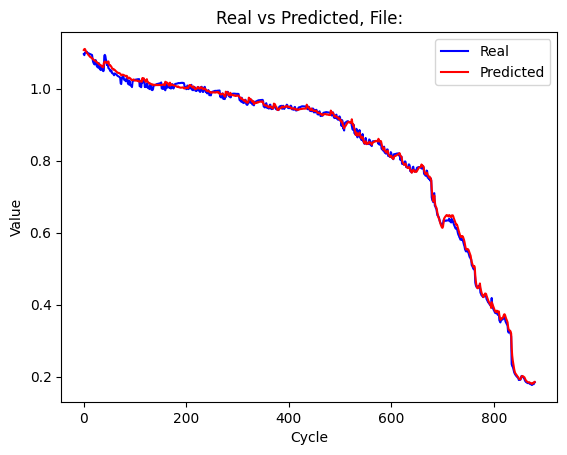

In [21]:
# Predici i valori sul dataset di test
y_pred = model.predict(X_test)
mae = np.sqrt(np.power((y_pred - y_test),2).mean())
print(y_pred.shape, mae)
plt.plot(y_test, label='Real', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.title('Real vs Predicted, File:')
plt.xlabel('Cycle')
plt.ylabel('Value')
plt.legend()
plt.show()